<h2 align="center">Codebasics DL Course: Vehicle Damage Detection Project</h2>

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timetorch
import torchvision.models as models
from matplotlib import pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Dataset

In [6]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [8]:
2300*0.75

1725.0

In [9]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [10]:
num_classes = len(dataset.classes)
num_classes

6

In [11]:
train_size = int(0.75*len(dataset))
val_size = len(dataset)-train_size
train_size, val_size

(1725, 575)

In [12]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,shuffle=True)

In [14]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [15]:
labels[1]

tensor(1)

In [16]:
images[1].shape

torch.Size([3, 224, 224])

In [17]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


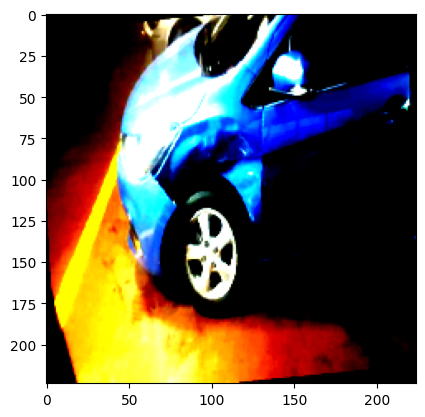

In [18]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

# Model 1 CNN

In [19]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),      # (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                   # (16,112,112)

            nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),                                     # (32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                    #( 64,28,28)

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x 

In [20]:
images.size(0)

32

In [21]:
len(train_loader.dataset)

1725

In [22]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader): 
            images, labels = images.to(device), labels.to(device)

            # zero_the parameter geadients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = [] 

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _,predicted= torch.max(outputs.data,1)
                total +=labels.size(0)
                correct +=(predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy: {100* correct/total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end-start} seconds")

    return all_labels, all_predictions

In [23]:
# Instantiate the model, loss function, and optimizer 

model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.75
Batch: 40, Epoch: 1, Loss: 1.68
Batch: 50, Epoch: 1, Loss: 1.79
Epoch [1/10], Avg Loss: 1.9010
*** Validation Accuracy: 37.74% ***
Batch: 10, Epoch: 2, Loss: 1.28
Batch: 20, Epoch: 2, Loss: 1.35
Batch: 30, Epoch: 2, Loss: 1.35
Batch: 40, Epoch: 2, Loss: 1.32
Batch: 50, Epoch: 2, Loss: 1.22
Epoch [2/10], Avg Loss: 1.3119
*** Validation Accuracy: 45.74% ***
Batch: 10, Epoch: 3, Loss: 1.23
Batch: 20, Epoch: 3, Loss: 1.24
Batch: 30, Epoch: 3, Loss: 1.32
Batch: 40, Epoch: 3, Loss: 1.22
Batch: 50, Epoch: 3, Loss: 0.97
Epoch [3/10], Avg Loss: 1.1861
*** Validation Accuracy: 54.61% ***
Batch: 10, Epoch: 4, Loss: 1.23
Batch: 20, Epoch: 4, Loss: 1.09
Batch: 30, Epoch: 4, Loss: 1.17
Batch: 40, Epoch: 4, Loss: 1.09
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 1.0103
*** Validation Accuracy: 55.48% ***
Batch: 10, Epoch: 5, Loss: 0.95
Batch: 20, Epoch: 5, Loss: 0.87
Batch: 30, Epoch: 5, Loss: 0

## Model 2: CNN with Regularization 

In [31]:
class CarClassifierCNNWithRegualarization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding = 1),   # (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                  # (16,112,112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                  # (32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                  # (64,28,28) 

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  
        )
    def forward(self, x):
        x = self.network(x)
        return x 

In [32]:
model = CarClassifierCNNWithRegualarization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 24.80
Batch: 20, Epoch: 1, Loss: 7.16
Batch: 30, Epoch: 1, Loss: 2.62
Batch: 40, Epoch: 1, Loss: 1.56
Batch: 50, Epoch: 1, Loss: 1.55
Epoch [1/10], Avg Loss: 9.2962
*** Validation Accuracy: 44.70% ***
Batch: 10, Epoch: 2, Loss: 1.68
Batch: 20, Epoch: 2, Loss: 1.37
Batch: 30, Epoch: 2, Loss: 1.37
Batch: 40, Epoch: 2, Loss: 1.56
Batch: 50, Epoch: 2, Loss: 1.47
Epoch [2/10], Avg Loss: 1.4534
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 3, Loss: 1.43
Batch: 20, Epoch: 3, Loss: 1.56
Batch: 30, Epoch: 3, Loss: 1.07
Batch: 40, Epoch: 3, Loss: 1.13
Batch: 50, Epoch: 3, Loss: 1.17
Epoch [3/10], Avg Loss: 1.3318
*** Validation Accuracy: 47.48% ***
Batch: 10, Epoch: 4, Loss: 0.97
Batch: 20, Epoch: 4, Loss: 1.19
Batch: 30, Epoch: 4, Loss: 1.18
Batch: 40, Epoch: 4, Loss: 1.29
Batch: 50, Epoch: 4, Loss: 0.93
Epoch [4/10], Avg Loss: 1.2569
*** Validation Accuracy: 45.57% ***
Batch: 10, Epoch: 5, Loss: 1.18
Batch: 20, Epoch: 5, Loss: 1.35
Batch: 30, Epoch: 5, Loss: 

# Model 3: Transfer Learning With EfficientNet

In [33]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [40]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
                                                                    
        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self,x):
        x = self.model(x)
        return x

In [38]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
      
criterion = nn.CrossEntropyLoss()
opimizer = optim.Adam(filter(lambda p: p.requires_grad ,model.parameters()), lr=0.001)
all_labels, all_predictions = train_model(model,criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.82
Batch: 20, Epoch: 1, Loss: 1.74
Batch: 30, Epoch: 1, Loss: 1.80
Batch: 40, Epoch: 1, Loss: 1.87
Batch: 50, Epoch: 1, Loss: 1.77
Epoch [1/10], Avg Loss: 1.8044
*** Validation Accuracy: 17.22% ***
Batch: 10, Epoch: 2, Loss: 1.76
Batch: 20, Epoch: 2, Loss: 1.82
Batch: 30, Epoch: 2, Loss: 1.86
Batch: 40, Epoch: 2, Loss: 1.90
Batch: 50, Epoch: 2, Loss: 1.81
Epoch [2/10], Avg Loss: 1.8193
*** Validation Accuracy: 15.65% ***
Batch: 10, Epoch: 3, Loss: 1.86
Batch: 20, Epoch: 3, Loss: 1.78
Batch: 30, Epoch: 3, Loss: 1.76
Batch: 40, Epoch: 3, Loss: 1.77
Batch: 50, Epoch: 3, Loss: 1.90
Epoch [3/10], Avg Loss: 1.8104
*** Validation Accuracy: 15.30% ***
Batch: 10, Epoch: 4, Loss: 1.85
Batch: 20, Epoch: 4, Loss: 1.82
Batch: 30, Epoch: 4, Loss: 1.82
Batch: 40, Epoch: 4, Loss: 1.86
Batch: 50, Epoch: 4, Loss: 1.83
Epoch [4/10], Avg Loss: 1.8157
*** Validation Accuracy: 15.83% ***
Batch: 10, Epoch: 5, Loss: 1.87
Batch: 20, Epoch: 5, Loss: 1.85
Batch: 30, Epoch: 5, Loss: 1

### Copied code from original file then run for 2nd time

In [36]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [37]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.69
Batch: 20, Epoch: 1, Loss: 1.56
Batch: 30, Epoch: 1, Loss: 1.33
Batch: 40, Epoch: 1, Loss: 1.23
Batch: 50, Epoch: 1, Loss: 1.15
Epoch [1/10], Avg Loss: 1.4847
*** Validation Accuracy: 54.43% ***
Batch: 10, Epoch: 2, Loss: 1.17
Batch: 20, Epoch: 2, Loss: 1.22
Batch: 30, Epoch: 2, Loss: 1.06
Batch: 40, Epoch: 2, Loss: 0.99
Batch: 50, Epoch: 2, Loss: 1.20
Epoch [2/10], Avg Loss: 1.1246
*** Validation Accuracy: 59.65% ***
Batch: 10, Epoch: 3, Loss: 1.18
Batch: 20, Epoch: 3, Loss: 1.02
Batch: 30, Epoch: 3, Loss: 1.00
Batch: 40, Epoch: 3, Loss: 0.99
Batch: 50, Epoch: 3, Loss: 0.94
Epoch [3/10], Avg Loss: 0.9983
*** Validation Accuracy: 64.35% ***
Batch: 10, Epoch: 4, Loss: 0.82
Batch: 20, Epoch: 4, Loss: 0.87
Batch: 30, Epoch: 4, Loss: 0.82
Batch: 40, Epoch: 4, Loss: 0.88
Batch: 50, Epoch: 4, Loss: 0.90
Epoch [4/10], Avg Loss: 0.9516
*** Validation Accuracy: 66.09% ***
Batch: 10, Epoch: 5, Loss: 0.80
Batch: 20, Epoch: 5, Loss: 0.74
Batch: 30, Epoch: 5, Loss: 0

## Model 4 : Transfer Learnning with ResNet

In [39]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        #Freeze all layers except the final fully connected layer 
        for param in self.model.parameters():
            param.requires_grad = False 

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad=True

        # Replace the final fully conncected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x 

In [40]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs = 10 )

Batch: 10, Epoch: 1, Loss: 0.94
Batch: 20, Epoch: 1, Loss: 0.58
Batch: 30, Epoch: 1, Loss: 0.60
Batch: 40, Epoch: 1, Loss: 0.55
Batch: 50, Epoch: 1, Loss: 0.64
Epoch [1/10], Avg Loss: 0.8113
*** Validation Accuracy: 66.09% ***
Batch: 10, Epoch: 2, Loss: 0.50
Batch: 20, Epoch: 2, Loss: 0.68
Batch: 30, Epoch: 2, Loss: 0.62
Batch: 40, Epoch: 2, Loss: 0.55
Batch: 50, Epoch: 2, Loss: 0.38
Epoch [2/10], Avg Loss: 0.5125
*** Validation Accuracy: 75.83% ***
Batch: 10, Epoch: 3, Loss: 0.54
Batch: 20, Epoch: 3, Loss: 0.33
Batch: 30, Epoch: 3, Loss: 0.26
Batch: 40, Epoch: 3, Loss: 0.27
Batch: 50, Epoch: 3, Loss: 0.49
Epoch [3/10], Avg Loss: 0.3616
*** Validation Accuracy: 77.39% ***
Batch: 10, Epoch: 4, Loss: 0.12
Batch: 20, Epoch: 4, Loss: 0.43
Batch: 30, Epoch: 4, Loss: 0.37
Batch: 40, Epoch: 4, Loss: 0.33
Batch: 50, Epoch: 4, Loss: 0.22
Epoch [4/10], Avg Loss: 0.2420
*** Validation Accuracy: 76.52% ***
Batch: 10, Epoch: 5, Loss: 0.10
Batch: 20, Epoch: 5, Loss: 0.09
Batch: 30, Epoch: 5, Loss: 0

# After Hyperparameter Tunung found optimum parameter for best prformance

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [42]:
model = CarClassifierResNet(num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.005)
labels, predictions = train_model(model, criterion, optimizer, epochs = 10)

Batch: 10, Epoch: 1, Loss: 0.97
Batch: 20, Epoch: 1, Loss: 1.03
Batch: 30, Epoch: 1, Loss: 0.59
Batch: 40, Epoch: 1, Loss: 0.80
Batch: 50, Epoch: 1, Loss: 0.52
Epoch [1/10], Avg Loss: 0.9388
*** Validation Accuracy: 67.30% ***
Batch: 10, Epoch: 2, Loss: 0.62
Batch: 20, Epoch: 2, Loss: 0.58
Batch: 30, Epoch: 2, Loss: 0.85
Batch: 40, Epoch: 2, Loss: 0.31
Batch: 50, Epoch: 2, Loss: 0.33
Epoch [2/10], Avg Loss: 0.5539
*** Validation Accuracy: 78.09% ***
Batch: 10, Epoch: 3, Loss: 0.30
Batch: 20, Epoch: 3, Loss: 0.38
Batch: 30, Epoch: 3, Loss: 0.48
Batch: 40, Epoch: 3, Loss: 0.57
Batch: 50, Epoch: 3, Loss: 0.26
Epoch [3/10], Avg Loss: 0.3667
*** Validation Accuracy: 73.57% ***
Batch: 10, Epoch: 4, Loss: 0.21
Batch: 20, Epoch: 4, Loss: 0.19
Batch: 30, Epoch: 4, Loss: 0.39
Batch: 40, Epoch: 4, Loss: 0.74
Batch: 50, Epoch: 4, Loss: 0.43
Epoch [4/10], Avg Loss: 0.2956
*** Validation Accuracy: 75.13% ***
Batch: 10, Epoch: 5, Loss: 0.16
Batch: 20, Epoch: 5, Loss: 0.21
Batch: 30, Epoch: 5, Loss: 0

## Model Evaluation using Confusion Matrix and Classification matrix

In [43]:
from sklearn.metrics import classification_report 
report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       128
           1       0.69      0.81      0.75       108
           2       0.89      0.87      0.88       121
           3       0.77      0.79      0.78        81
           4       0.82      0.58      0.68        71
           5       0.70      0.89      0.79        66

    accuracy                           0.79       575
   macro avg       0.79      0.78      0.78       575
weighted avg       0.80      0.79      0.79       575



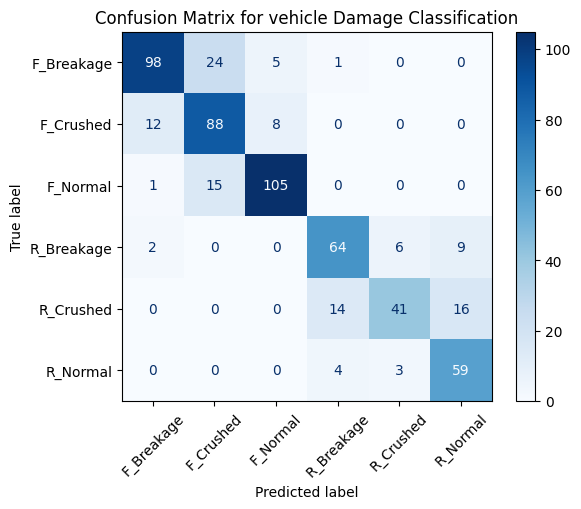

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for vehicle Damage Classification")
plt.show()

In [69]:
# Save the model

In [45]:
torch.save(model.state_dict(), 'saved_model.pth')

In [46]:
torch.save(model.state_dict(), 'saved_model1.pth')